# Data/MC Validation of Background Processes with Alternate Models

This notebook contains the background data/MC plots for the various models, including the plots generated for the 8/30/19 LLP meeting. First, just background MC plots are done, then data/MC plots. Also, note: the background files and weights used came from Weinan's backgrounds_nonempty.json and backgrounds_scale.json files, not from fileGrabber files (see fileGrabberinterface for more details on why).

In [39]:
%matplotlib inline
import os
import re
import time
import json
import uproot
import awkward
import graphviz
import xgboost as xgb
import pandas as pd
import numpy as np
import utils.histoHelpers as uhh
import utils.uprootHelpers as uuh
import mvatrain.preprocessors as mpp
import matplotlib.pyplot as plt
import coffea.processor as processor
from mvatrain.metfilter import *
from awkward import JaggedArray
from os.path import join
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from mvatrain.ROCPlot import ROCPlot
from mvatrain.hist_errorbars import hist_errorbars
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.correction import get_pu_weights_function, get_ttbar_weight, get_nlo_weight_function

In [20]:
np.seterr(divide='ignore', invalid='ignore', over='ignore')
np.set_printoptions(threshold=np.inf)
TIME_STR = "190812"
TIME_STR2 = "190815"
TIME_STR_CURRENT = "190827"
DATA_DIR = join(os.environ["FFANA_BASE"], f"mvatrain/data") #base data directory
OUTPUT_DIR = join(os.environ["FFANA_BASE"], f"mvatrain/outputs/earl_grey_strong_redux")  #model
REPORT_DIR = join(os.environ["FFANA_BASE"], f"mvatrain/reports/{TIME_STR_CURRENT}") #reports and plots
FIG_DIR = join(os.environ["FFANA_BASE"], f"mvatrain/datamc_models")

In [3]:
OUTPUT_DIR_CURRENT = join(os.environ["FFANA_BASE"], f"mvatrain/outputs/earl_grey_strong_redux")
OUTPUT_DIR_MU = join(os.environ["FFANA_BASE"], f"mvatrain/outputs/english_breakfast_redux")
OUTPUT_DIR_ELEC = join(os.environ["FFANA_BASE"], f"mvatrain/outputs/irish_breakfast_redux")

print("loading model...")
xgbm_current = xgb.Booster({"nthread": 16})
xgbm_current.load_model(join(OUTPUT_DIR_CURRENT, "model_optimized/model.bin"))
if xgbm_current.attributes().get('SAVED_PARAM_predictor', None)=='gpu_predictor':
    xgbm_current.set_attr(SAVED_PARAM_predictor=None)
print("model loaded.")

print("loading model...")
xgbm_mu = xgb.Booster({"nthread": 16})
xgbm_mu.load_model(join(OUTPUT_DIR_MU, "model_optimized/model.bin"))
if xgbm_mu.attributes().get('SAVED_PARAM_predictor', None)=='gpu_predictor':
    xgbm_mu.set_attr(SAVED_PARAM_predictor=None)
print("model loaded.")

print("loading model...")
xgbm_elec = xgb.Booster({"nthread": 16})
xgbm_elec.load_model(join(OUTPUT_DIR_ELEC, "model_optimized/model.bin"))
if xgbm_elec.attributes().get('SAVED_PARAM_predictor', None)=='gpu_predictor':
    xgbm_elec.set_attr(SAVED_PARAM_predictor=None)
print("model loaded.")

loading model...
model loaded.
loading model...
model loaded.
loading model...
model loaded.


# MC Background

In [5]:
datasets_=json.load(open('backgrounds_nonempty.json'))
scales_=json.load(open('backgrounds_scale.json'))

# flatten datasets
datasets = {}
for group in datasets_:
    for tag in datasets_[group]:
        files = datasets_[group][tag]
        datasets[tag] = {'files': files, 'treename': 'ffNtuplizer/ffNtuple'}

# flatten scales
scales = {}
for group in scales_:
    for tag in scales_[group]:
        scales[tag] = scales_[group][tag]

lumi = 60.432*1e3
for k in scales:
    scales[k] *= lumi

# mapping
mapping = {}
for k in datasets_: mapping[k] = list(datasets_[k])

## Current Model, MC Background:

In [26]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis  = hist.Cat('dataset', 'signal datasets')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        neufrac_axis  = hist.Bin("neufrac", "neutral energy fraction", 50, 0, 1)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lambda', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsilon', 'jet sub - epsilon', 50, 0, 0.25)
        ecf1_axis     = hist.Bin('ecf1', 'energy correlation function - e1', 50, 0, 750)
        ecf2_axis     = hist.Bin('ecf2', 'energy correlation function - e2', 50, 0, 2000)
        ecf3_axis     = hist.Bin('ecf3', 'energy correlation function - e3', 50, 0, 1000)
        mva_axis      = hist.Bin('mva', "BDT prediction value", 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis),
            "neufrac": hist.Hist("#counts/0.02", dataset_axis, neufrac_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis),
            "lambda": hist.Hist("#counts/0.16", dataset_axis, lambda_axis),
            "epsilon": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis),
            "ecf1": hist.Hist("#counts/25", dataset_axis, ecf1_axis),
            "ecf2": hist.Hist("#counts/40", dataset_axis, ecf2_axis),
            "ecf3": hist.Hist("#counts/20", dataset_axis, ecf3_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)

        wnlo = np.ones_like(df.size)
        if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
            genparticles = JaggedCandidateArray.candidatesfromcounts(
                df['gen_p4'],
                px=df['gen_p4.fCoordinates.fX'],
                py=df['gen_p4.fCoordinates.fY'],
                pz=df['gen_p4.fCoordinates.fZ'],
                energy=df['gen_p4.fCoordinates.fT'],
                pid=df['gen_pid'],
            )
            gentops = genparticles[np.abs(genparticles.pid)==6]
            genws = genparticles[np.abs(genparticles.pid)==24]
            genzs = genparticles[np.abs(genparticles.pid)==23]

            if 'TTJets' in dataset:
                wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
            elif 'WJets' in dataset:
                wnlo = self.nlo_w(genws[0].p4.pt.sum())
            elif 'DYJets' in dataset:
                wnlo = self.nlo_z(genzs[0].p4.pt.sum())
        wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        absd0 = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0)
        maxd0_ = absd0.max()
        mind0_ = absd0.min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'], **{
            "px": df['pfjet_p4.fCoordinates.fX'],
            "py": df['pfjet_p4.fCoordinates.fY'],
            "pz": df['pfjet_p4.fCoordinates.fZ'],
            "energy": df['pfjet_p4.fCoordinates.fT'],
            "neufrac": ((df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT']),
            "maxd0": maxd0_.content,
            "mind0": mind0_.content,
            "tkiso": df['pfjet_tkIsolation05'],
            "pfiso": df['pfjet_pfIsolation05'],
            "spreadpt": df['pfjet_ptDistribution'],
            "spreaddr": df['pfjet_dRSpread'],
            "lambda": df['pfjet_subjet_lambda'],
            "epsilon": df['pfjet_subjet_epsilon'],
            "ecf1": df['pfjet_subjet_ecf1'],
            "ecf2": df['pfjet_subjet_ecf2'],
            "ecf3": df['pfjet_subjet_ecf3'],
            })
        
        vals={
            'target': leptonjets.pt.zeros_like().flatten(),
            'pt': leptonjets.pt.flatten(),
            'eta': leptonjets.eta.flatten(),
        }
        
        vals.update( {k: leptonjets[k].flatten() for k in output.keys() if (k not in vals and k != 'mva')} )
        
        dfleptonjets = pd.DataFrame(vals)
        
        dfleptonjets.fillna(0)
        
        feature_cols = [n for n in dfleptonjets.keys() if n != "target"]

        dfleptonjets2 = dfleptonjets[feature_cols]
        
        xglj = xgb.DMatrix(dfleptonjets2)
        
        predictions = xgbm_current.predict(xglj)
        
        offsets = leptonjets.pt.offsets
        jaggedpredictions = JaggedArray.fromoffsets(offsets, predictions)
        leptonjets.add_attributes(mva=jaggedpredictions)
        
        # control region selections
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()

        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output

        leadingLjPair = leptonjetpair[sumpt.argmax()]
        controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
        leptonjets_ = dileptonjets[controlregion.flatten()]
        wgt = wgt[controlregion.flatten()]

        wgt_ = (leptonjets_.pt.ones_like()*wgt).flatten()
        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=wgt_)
        output['eta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), weight=wgt_)
        output['neufrac'].fill(dataset=dataset, neufrac=leptonjets_.neufrac.flatten(), weight=wgt_)
        output['maxd0'].fill(dataset=dataset, maxd0=leptonjets_.maxd0.flatten(), weight=wgt_)
        output['mind0'].fill(dataset=dataset, mind0=leptonjets_.mind0.flatten(), weight=wgt_)
        output['tkiso'].fill(dataset=dataset, tkiso=leptonjets_.tkiso.flatten(), weight=wgt_)
        output['pfiso'].fill(dataset=dataset, pfiso=leptonjets_.pfiso.flatten(), weigth=wgt_)
        output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets_.spreadpt.flatten(), weight=wgt_)
        output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets_.spreaddr.flatten(), weight=wgt_)
        output['lambda']  .fill(**{"dataset": dataset, "lambda": leptonjets_['lambda'].flatten(), 'weight': wgt_})
        output['epsilon'].fill(dataset=dataset, epsilon=leptonjets_.epsilon.flatten(), weight=wgt_)
        output['ecf1'].fill(dataset=dataset, ecf1=leptonjets_.ecf1.flatten(), weight=wgt_)
        output['ecf2'].fill(dataset=dataset, ecf2=leptonjets_.ecf2.flatten(), weight=wgt_)
        output['ecf3'].fill(dataset=dataset, ecf3=leptonjets_.ecf3.flatten(), weight=wgt_)
        output['mva'].fill(dataset=dataset, mva=leptonjets_.mva.flatten(), weight=wgt_)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        # scale
        for k in origidentity:
            accumulator[k].scale(scales, axis='dataset')
        # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        return accumulator

In [27]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 4302/4302 [14:44<00:00,  1.91items/s]


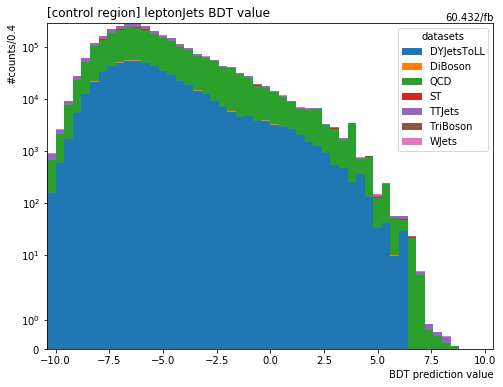

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['mva_cat'], overlay='cat', stack=True, ax=ax, overflow='all')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets BDT value', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_yscale('symlog')
ax.set_ylim([0, None]);

## Electron Model, MC Background:

In [6]:
class LeptonJetsElecProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis  = hist.Cat('dataset', 'signal datasets')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        neufrac_axis  = hist.Bin("neufrac", "neutral energy fraction", 50, 0, 1)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lambda', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsilon', 'jet sub - epsilon', 50, 0, 0.25)
        ecf1_axis     = hist.Bin('ecf1', 'energy correlation function - e1', 50, 0, 750)
        ecf2_axis     = hist.Bin('ecf2', 'energy correlation function - e2', 50, 0, 2000)
        ecf3_axis     = hist.Bin('ecf3', 'energy correlation function - e3', 50, 0, 1000)
        mva_axis      = hist.Bin('mva', "BDT prediction value", 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis),
            "neufrac": hist.Hist("#counts/0.02", dataset_axis, neufrac_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis),
            "lambda": hist.Hist("#counts/0.16", dataset_axis, lambda_axis),
            "epsilon": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis),
            "ecf1": hist.Hist("#counts/25", dataset_axis, ecf1_axis),
            "ecf2": hist.Hist("#counts/40", dataset_axis, ecf2_axis),
            "ecf3": hist.Hist("#counts/20", dataset_axis, ecf3_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)

        wnlo = np.ones_like(df.size)
        if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
            genparticles = JaggedCandidateArray.candidatesfromcounts(
                df['gen_p4'],
                px=df['gen_p4.fCoordinates.fX'],
                py=df['gen_p4.fCoordinates.fY'],
                pz=df['gen_p4.fCoordinates.fZ'],
                energy=df['gen_p4.fCoordinates.fT'],
                pid=df['gen_pid'],
            )
            gentops = genparticles[np.abs(genparticles.pid)==6]
            genws = genparticles[np.abs(genparticles.pid)==24]
            genzs = genparticles[np.abs(genparticles.pid)==23]

            if 'TTJets' in dataset:
                wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
            elif 'WJets' in dataset:
                wnlo = self.nlo_w(genws[0].p4.pt.sum())
            elif 'DYJets' in dataset:
                wnlo = self.nlo_z(genzs[0].p4.pt.sum())
        wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        absd0 = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0)
        maxd0_ = absd0.max()
        mind0_ = absd0.min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'], **{
            "px": df['pfjet_p4.fCoordinates.fX'],
            "py": df['pfjet_p4.fCoordinates.fY'],
            "pz": df['pfjet_p4.fCoordinates.fZ'],
            "energy": df['pfjet_p4.fCoordinates.fT'],
            "neufrac": ((df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT']),
            "maxd0": maxd0_.content,
            "mind0": mind0_.content,
            "tkiso": df['pfjet_tkIsolation05'],
            "pfiso": df['pfjet_pfIsolation05'],
            "spreadpt": df['pfjet_ptDistribution'],
            "spreaddr": df['pfjet_dRSpread'],
            "lambda": df['pfjet_subjet_lambda'],
            "epsilon": df['pfjet_subjet_epsilon'],
            "ecf1": df['pfjet_subjet_ecf1'],
            "ecf2": df['pfjet_subjet_ecf2'],
            "ecf3": df['pfjet_subjet_ecf3'],
            })
        
        vals={
            'target': leptonjets.pt.zeros_like().flatten(),
            'pt': leptonjets.pt.flatten(),
            'eta': leptonjets.eta.flatten(),
        }
        
        vals.update( {k: leptonjets[k].flatten() for k in output.keys() if (k not in vals and k != 'mva')} )
        
        dfleptonjets = pd.DataFrame(vals)
        
        dfleptonjets.fillna(0)
        
        feature_cols = [n for n in dfleptonjets.keys() if n != "target"]

        dfleptonjets2 = dfleptonjets[feature_cols]
        
        xglj = xgb.DMatrix(dfleptonjets2)
        
        predictions = xgbm_elec.predict(xglj)
        
        offsets = leptonjets.pt.offsets
        jaggedpredictions = JaggedArray.fromoffsets(offsets, predictions)
        leptonjets.add_attributes(mva=jaggedpredictions)
        
        elecmask = leptonjets.neufrac > 0.8
        leptonjets = leptonjets[elecmask]
        
        # control region selections
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()

        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output

        leadingLjPair = leptonjetpair[sumpt.argmax()]
        controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
        leptonjets_ = dileptonjets[controlregion.flatten()]
        wgt = wgt[controlregion.flatten()]

        wgt_ = (leptonjets_.pt.ones_like()*wgt).flatten()
        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=wgt_)
        output['eta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), weight=wgt_)
        output['neufrac'].fill(dataset=dataset, neufrac=leptonjets_.neufrac.flatten(), weight=wgt_)
        output['maxd0'].fill(dataset=dataset, maxd0=leptonjets_.maxd0.flatten(), weight=wgt_)
        output['mind0'].fill(dataset=dataset, mind0=leptonjets_.mind0.flatten(), weight=wgt_)
        output['tkiso'].fill(dataset=dataset, tkiso=leptonjets_.tkiso.flatten(), weight=wgt_)
        output['pfiso'].fill(dataset=dataset, pfiso=leptonjets_.pfiso.flatten(), weigth=wgt_)
        output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets_.spreadpt.flatten(), weight=wgt_)
        output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets_.spreaddr.flatten(), weight=wgt_)
        output['lambda']  .fill(**{"dataset": dataset, "lambda": leptonjets_['lambda'].flatten(), 'weight': wgt_})
        output['epsilon'].fill(dataset=dataset, epsilon=leptonjets_.epsilon.flatten(), weight=wgt_)
        output['ecf1'].fill(dataset=dataset, ecf1=leptonjets_.ecf1.flatten(), weight=wgt_)
        output['ecf2'].fill(dataset=dataset, ecf2=leptonjets_.ecf2.flatten(), weight=wgt_)
        output['ecf3'].fill(dataset=dataset, ecf3=leptonjets_.ecf3.flatten(), weight=wgt_)
        output['mva'].fill(dataset=dataset, mva=leptonjets_.mva.flatten(), weight=wgt_)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        # scale
        for k in origidentity:
            accumulator[k].scale(scales, axis='dataset')
        # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        return accumulator

In [7]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetsElecProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 4302/4302 [13:56<00:00,  5.14items/s]


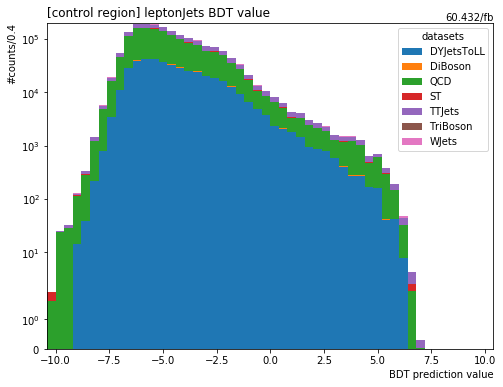

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['mva_cat'], overlay='cat', stack=True, ax=ax, overflow='all')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets BDT value', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_yscale('symlog')
ax.set_ylim([0, None]);

## Muon Model, MC Background:

In [9]:
class LeptonJetsMuProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis  = hist.Cat('dataset', 'signal datasets')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        neufrac_axis  = hist.Bin("neufrac", "neutral energy fraction", 50, 0, 1)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lambda', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsilon', 'jet sub - epsilon', 50, 0, 0.25)
        ecf1_axis     = hist.Bin('ecf1', 'energy correlation function - e1', 50, 0, 750)
        ecf2_axis     = hist.Bin('ecf2', 'energy correlation function - e2', 50, 0, 2000)
        ecf3_axis     = hist.Bin('ecf3', 'energy correlation function - e3', 50, 0, 1000)
        mva_axis      = hist.Bin('mva', "BDT prediction value", 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis),
            "neufrac": hist.Hist("#counts/0.02", dataset_axis, neufrac_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis),
            "lambda": hist.Hist("#counts/0.16", dataset_axis, lambda_axis),
            "epsilon": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis),
            "ecf1": hist.Hist("#counts/25", dataset_axis, ecf1_axis),
            "ecf2": hist.Hist("#counts/40", dataset_axis, ecf2_axis),
            "ecf3": hist.Hist("#counts/20", dataset_axis, ecf3_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)

        wnlo = np.ones_like(df.size)
        if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
            genparticles = JaggedCandidateArray.candidatesfromcounts(
                df['gen_p4'],
                px=df['gen_p4.fCoordinates.fX'],
                py=df['gen_p4.fCoordinates.fY'],
                pz=df['gen_p4.fCoordinates.fZ'],
                energy=df['gen_p4.fCoordinates.fT'],
                pid=df['gen_pid'],
            )
            gentops = genparticles[np.abs(genparticles.pid)==6]
            genws = genparticles[np.abs(genparticles.pid)==24]
            genzs = genparticles[np.abs(genparticles.pid)==23]

            if 'TTJets' in dataset:
                wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
            elif 'WJets' in dataset:
                wnlo = self.nlo_w(genws[0].p4.pt.sum())
            elif 'DYJets' in dataset:
                wnlo = self.nlo_z(genzs[0].p4.pt.sum())
        wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        absd0 = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0)
        maxd0_ = absd0.max()
        mind0_ = absd0.min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'], **{
            "px": df['pfjet_p4.fCoordinates.fX'],
            "py": df['pfjet_p4.fCoordinates.fY'],
            "pz": df['pfjet_p4.fCoordinates.fZ'],
            "energy": df['pfjet_p4.fCoordinates.fT'],
            "neufrac": ((df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT']),
            "maxd0": maxd0_.content,
            "mind0": mind0_.content,
            "tkiso": df['pfjet_tkIsolation05'],
            "pfiso": df['pfjet_pfIsolation05'],
            "spreadpt": df['pfjet_ptDistribution'],
            "spreaddr": df['pfjet_dRSpread'],
            "lambda": df['pfjet_subjet_lambda'],
            "epsilon": df['pfjet_subjet_epsilon'],
            "ecf1": df['pfjet_subjet_ecf1'],
            "ecf2": df['pfjet_subjet_ecf2'],
            "ecf3": df['pfjet_subjet_ecf3'],
            })
        
        vals={
            'target': leptonjets.pt.zeros_like().flatten(),
            'pt': leptonjets.pt.flatten(),
            'eta': leptonjets.eta.flatten(),
        }
        
        vals.update( {k: leptonjets[k].flatten() for k in output.keys() if (k not in vals and k != 'mva')} )
        
        dfleptonjets = pd.DataFrame(vals)
        
        dfleptonjets.fillna(0)
        
        feature_cols = [n for n in dfleptonjets.keys() if n != "target"]

        dfleptonjets2 = dfleptonjets[feature_cols]
        
        xglj = xgb.DMatrix(dfleptonjets2)
        
        predictions = xgbm_mu.predict(xglj)
        
        offsets = leptonjets.pt.offsets
        jaggedpredictions = JaggedArray.fromoffsets(offsets, predictions)
        leptonjets.add_attributes(mva=jaggedpredictions)
        
        mumask = leptonjets.neufrac <= 0.8
        leptonjets = leptonjets[mumask]
        
        # control region selections
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()

        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output

        leadingLjPair = leptonjetpair[sumpt.argmax()]
        controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
        leptonjets_ = dileptonjets[controlregion.flatten()]
        wgt = wgt[controlregion.flatten()]

        wgt_ = (leptonjets_.pt.ones_like()*wgt).flatten()
        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=wgt_)
        output['eta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), weight=wgt_)
        output['neufrac'].fill(dataset=dataset, neufrac=leptonjets_.neufrac.flatten(), weight=wgt_)
        output['maxd0'].fill(dataset=dataset, maxd0=leptonjets_.maxd0.flatten(), weight=wgt_)
        output['mind0'].fill(dataset=dataset, mind0=leptonjets_.mind0.flatten(), weight=wgt_)
        output['tkiso'].fill(dataset=dataset, tkiso=leptonjets_.tkiso.flatten(), weight=wgt_)
        output['pfiso'].fill(dataset=dataset, pfiso=leptonjets_.pfiso.flatten(), weigth=wgt_)
        output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets_.spreadpt.flatten(), weight=wgt_)
        output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets_.spreaddr.flatten(), weight=wgt_)
        output['lambda']  .fill(**{"dataset": dataset, "lambda": leptonjets_['lambda'].flatten(), 'weight': wgt_})
        output['epsilon'].fill(dataset=dataset, epsilon=leptonjets_.epsilon.flatten(), weight=wgt_)
        output['ecf1'].fill(dataset=dataset, ecf1=leptonjets_.ecf1.flatten(), weight=wgt_)
        output['ecf2'].fill(dataset=dataset, ecf2=leptonjets_.ecf2.flatten(), weight=wgt_)
        output['ecf3'].fill(dataset=dataset, ecf3=leptonjets_.ecf3.flatten(), weight=wgt_)
        output['mva'].fill(dataset=dataset, mva=leptonjets_.mva.flatten(), weight=wgt_)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        # scale
        for k in origidentity:
            accumulator[k].scale(scales, axis='dataset')
        # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        return accumulator

In [10]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetsMuProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 4302/4302 [14:37<00:00,  4.90items/s]


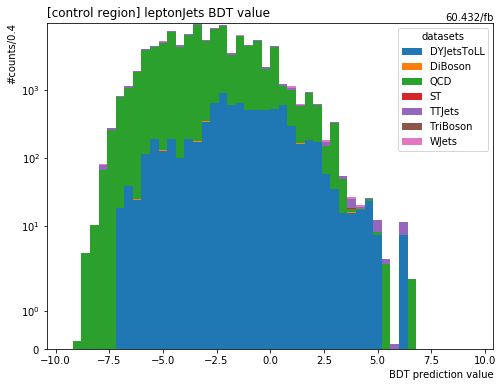

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['mva_cat'], overlay='cat', stack=True, ax=ax, overflow='all')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets BDT value', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_yscale('symlog')
ax.set_ylim([0, None]);

# Data Background

In [4]:
########## backgrounds ##########
bkgdatasets_=json.load(open('backgrounds_nonempty.json'))
bkgscales_=json.load(open('backgrounds_scale.json'))

# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        files = bkgdatasets_[group][tag]
        bkgdatasets[tag] = {'files': files, 'treename': 'ffNtuplizer/ffNtuple'}

# flatten scales
bkgscales = {}
for group in bkgscales_:
    for tag in bkgscales_[group]:
        bkgscales[tag] = bkgscales_[group][tag]

lumi = 59.74*1e3
for k in bkgscales:
    bkgscales[k] *= lumi

# mapping
bkgmapping = {}
for k in bkgdatasets_: bkgmapping[k] = list(bkgdatasets_[k])
####################################

########## data ##########
datadatasets_=json.load(open('control_data2018.json'))
datadatasets = dict(
    A={'files': datadatasets_['A'], 'treename': 'ffNtuplizer/ffNtuple'},
    B={'files': datadatasets_['B'], 'treename': 'ffNtuples/ffNtuple'},
    C={'files': datadatasets_['C'], 'treename': 'ffNtuples/ffNtuple'},
    D={'files': datadatasets_['D'], 'treename': 'ffNtuples/ffNtuple'},
)
datamapping = {'data': list('ABCD')}
####################################

########## combine together ##########
datasets = {}
datasets.update(bkgdatasets)
datasets.update(datadatasets)

mapping = {}
mapping.update(bkgmapping)
mapping.update(datamapping)
####################################

notdata = re.compile('(?!data)')

In [5]:
fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

## Current Model, Data Background

In [40]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        neufrac_axis      = hist.Bin("neufrac", "neutral energy fraction", 50, 0, 1.001)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lambda', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsilon', 'jet sub - epsilon', 50, 0, 0.25)
        ecf1_axis    = hist.Bin('ecf1', 'energy correlation function - e1', 50, 0, 200)
        ecf2_axis    = hist.Bin('ecf2', 'energy correlation function - e2', 50, 0, 500)
        ecf3_axis    = hist.Bin('ecf3', 'energy correlation function - e3', 50, 0, 300)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis),
            "neufrac": hist.Hist("#counts/0.02", dataset_axis, neufrac_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis),
            "lambda": hist.Hist("#counts/0.16", dataset_axis, lambda_axis),
            "epsilon": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis),
            "ecf1": hist.Hist("#counts/4", dataset_axis, ecf1_axis),
            "ecf2": hist.Hist("#counts/10", dataset_axis, ecf2_axis),
            "ecf3": hist.Hist("#counts/6", dataset_axis, ecf3_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        
        if len(dataset)!=1:
            #wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            #wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'],
                    py=df['gen_p4.fCoordinates.fY'],
                    pz=df['gen_p4.fCoordinates.fZ'],
                    energy=df['gen_p4.fCoordinates.fT'],
                    pid=df['gen_pid'],
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            #wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        absd0 = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0)
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'], **{
            "px": df['pfjet_p4.fCoordinates.fX'],
            "py": df['pfjet_p4.fCoordinates.fY'],
            "pz": df['pfjet_p4.fCoordinates.fZ'],
            "energy": df['pfjet_p4.fCoordinates.fT'],
            "neufrac": ((df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT']),
            "maxd0": absd0.max().content,
            "mind0": absd0.min().content,
            "tkiso": df['pfjet_tkIsolation05'],
            "pfiso": df['pfjet_pfIsolation05'],
            "spreadpt": df['pfjet_ptDistribution'],
            "spreaddr": df['pfjet_dRSpread'],
            "lambda": df['pfjet_subjet_lambda'],
            "epsilon": df['pfjet_subjet_epsilon'],
            "ecf1": df['pfjet_subjet_ecf1'],
            "ecf2": df['pfjet_subjet_ecf2'],
            "ecf3": df['pfjet_subjet_ecf3'],
            })
        
        vals={
            'target': leptonjets.pt.zeros_like().flatten(),
            'pt': leptonjets.pt.flatten(),
            'eta': leptonjets.eta.flatten(),
        }
        
        vals.update( {k: leptonjets[k].flatten() for k in output.keys() if (k not in vals and k != 'mva')} )
        
        dfleptonjets = pd.DataFrame(vals)
        
        dfleptonjets.fillna(0)
        
        feature_cols = [n for n in dfleptonjets.keys() if n != "target"]

        dfleptonjets2 = dfleptonjets[feature_cols]
        
        xglj = xgb.DMatrix(dfleptonjets2)
        
        predictions = xgbm_current.predict(xglj)
        
        offsets = leptonjets.pt.offsets
        jaggedpredictions = JaggedArray.fromoffsets(offsets, predictions)
        leptonjets.add_attributes(mva=jaggedpredictions)
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
        leptonjets_ = dileptonjets[controlregion.flatten()]
        wgt = wgt[controlregion.flatten()]
        wgts= (leptonjets_.pt.ones_like()*wgt).flatten()

        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=wgts)
        output['eta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), weight=wgts)
        output['neufrac'].fill(dataset=dataset, neufrac=leptonjets_.neufrac.flatten(), weight=wgts)
        output['maxd0'].fill(dataset=dataset, maxd0=leptonjets_.maxd0.flatten(), weight=wgts)
        output['mind0'].fill(dataset=dataset, mind0=leptonjets_.mind0.flatten(), weight=wgts)
        output['tkiso'].fill(dataset=dataset, tkiso=leptonjets_.tkiso.flatten(), weight=wgts)
        output['pfiso'].fill(dataset=dataset, pfiso=leptonjets_.pfiso.flatten(), weight=wgts)
        output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets_.spreadpt.flatten(), weight=wgts)
        output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets_.spreaddr.flatten(), weight=wgts)
        output['lambda']  .fill(**{"dataset": dataset, "lambda": leptonjets_['lambda'].flatten(), 'weight': wgts})
        output['epsilon'].fill(dataset=dataset, epsilon=leptonjets_.epsilon.flatten(), weight=wgts)
        output['ecf1'].fill(dataset=dataset, ecf1=leptonjets_.ecf1.flatten(), weight=wgts)
        output['ecf2'].fill(dataset=dataset, ecf2=leptonjets_.ecf2.flatten(), weight=wgts)
        output['ecf3'].fill(dataset=dataset, ecf3=leptonjets_.ecf3.flatten(), weight=wgts)
        output['mva'].fill(dataset=dataset, mva=leptonjets_.mva.flatten(), weight=wgts)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        
        for k in origidentity:
            # scale
            accumulator[k].scale(bkgscales, axis='dataset')
            # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        
        return accumulator

In [41]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 6847/6847 [17:14<00:00,  6.62items/s]


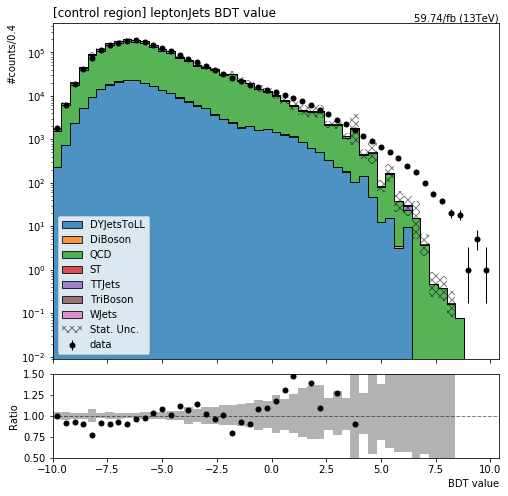

In [25]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['mva_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['mva_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['mva_cat']['data'].sum('cat'), output['mva_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets BDT value', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

#plt.savefig(join(FIG_DIR, "currentmodel_BDT.pdf"), bbox_inches='tight')
#plt.close()

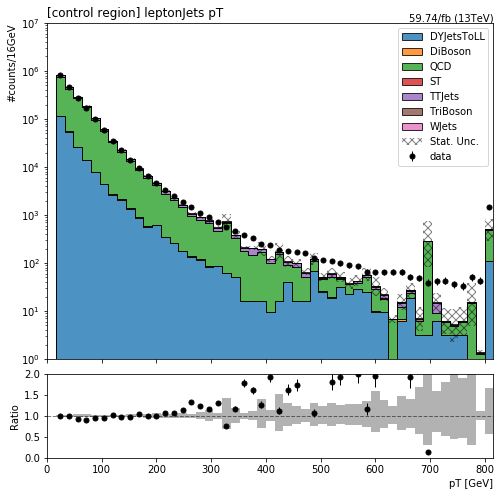

In [26]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['pt_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['pt_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['pt_cat']['data'].sum('cat'), output['pt_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets pT', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

#plt.savefig(join(FIG_DIR, "currentmodel_Pt.pdf"), bbox_inches='tight')
#plt.close()

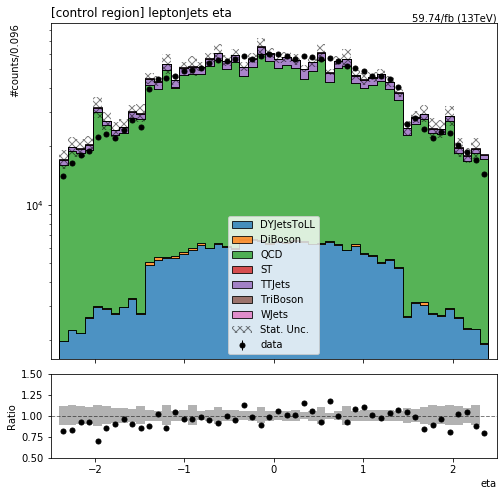

In [42]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['eta_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='all',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['eta_cat']['data'], overlay='cat', ax=ax,
           overflow='all', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['eta_cat']['data'].sum('cat'), output['eta_cat'][notdata].sum('cat'),
              ax=rax, overflow='all', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets eta', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

plt.savefig(join(FIG_DIR, "totalbkg_eta.pdf"), bbox_inches='tight')

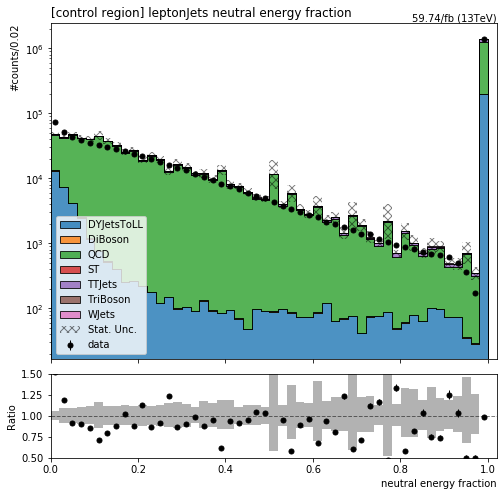

In [45]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['neufrac_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['neufrac_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['neufrac_cat']['data'].sum('cat'), output['neufrac_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets neutral energy fraction', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

plt.savefig(join(FIG_DIR, "totalbkg_neufrac.pdf"), bbox_inches='tight')

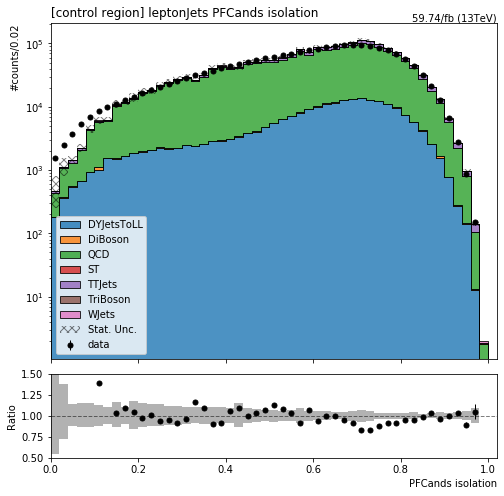

In [44]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['pfiso_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['pfiso_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['pfiso_cat']['data'].sum('cat'), output['pfiso_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets PFCands isolation', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

plt.savefig(join(FIG_DIR, "totalbkg_pfiso.pdf"), bbox_inches='tight')

In [46]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        mass_axis = hist.Bin("mass", "invM [GeV]", 50, 0, 500)
        dphi_axis = hist.Bin('dphi', "$\Delta\Phi$", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("#counts/10GeV", dataset_axis, mass_axis),
            'dphi': hist.Hist("#counts/$\pi$/50", dataset_axis, dphi_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        
        if len(dataset)!=1:
            #wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            #wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'],
                    py=df['gen_p4.fCoordinates.fY'],
                    pz=df['gen_p4.fCoordinates.fZ'],
                    energy=df['gen_p4.fCoordinates.fT'],
                    pid=df['gen_pid'],
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            #wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
        leadingLjPair_ = leadingLjPair[controlregion]
        dphi_ = np.abs(leadingLjPair_.i0.p4.delta_phi(leadingLjPair_.i1.p4))
        wgt = wgt[controlregion.flatten()]

        output['mass'].fill(dataset=dataset, mass=leadingLjPair_.mass.flatten(), weight=wgt)
        output['dphi'].fill(dataset=dataset, dphi=dphi_.flatten(), weight=wgt)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        
        for k in origidentity:
            # scale
            accumulator[k].scale(bkgscales, axis='dataset')
            # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        return accumulator

In [47]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 6847/6847 [08:49<00:00, 12.92items/s]


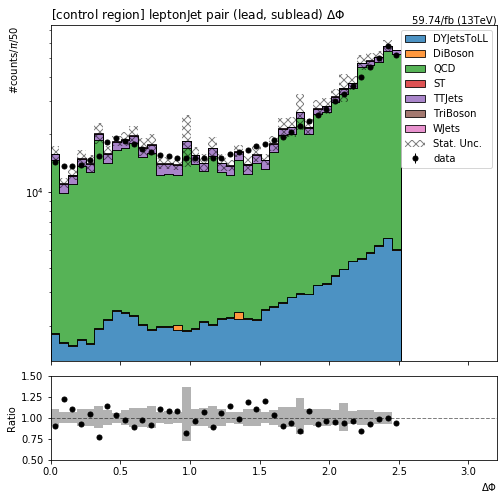

In [48]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['dphi_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['dphi_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['dphi_cat']['data'].sum('cat'), output['dphi_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5, 1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJet pair (lead, sublead) $\Delta\Phi$', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

plt.savefig(join(FIG_DIR, "totalbkg_dphi.pdf"), bbox_inches='tight')

## Electron Model, Data Background

In [27]:
class LeptonJetsElecProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        neufrac_axis      = hist.Bin("neufrac", "neutral energy fraction", 50, 0, 1.001)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lambda', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsilon', 'jet sub - epsilon', 50, 0, 0.25)
        ecf1_axis    = hist.Bin('ecf1', 'energy correlation function - e1', 50, 0, 200)
        ecf2_axis    = hist.Bin('ecf2', 'energy correlation function - e2', 50, 0, 500)
        ecf3_axis    = hist.Bin('ecf3', 'energy correlation function - e3', 50, 0, 300)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis),
            "neufrac": hist.Hist("#counts/0.02", dataset_axis, neufrac_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis),
            "lambda": hist.Hist("#counts/0.16", dataset_axis, lambda_axis),
            "epsilon": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis),
            "ecf1": hist.Hist("#counts/4", dataset_axis, ecf1_axis),
            "ecf2": hist.Hist("#counts/10", dataset_axis, ecf2_axis),
            "ecf3": hist.Hist("#counts/6", dataset_axis, ecf3_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        
        if len(dataset)!=1:
            #wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            #wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'],
                    py=df['gen_p4.fCoordinates.fY'],
                    pz=df['gen_p4.fCoordinates.fZ'],
                    energy=df['gen_p4.fCoordinates.fT'],
                    pid=df['gen_pid'],
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            #wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        absd0 = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0)
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'], **{
            "px": df['pfjet_p4.fCoordinates.fX'],
            "py": df['pfjet_p4.fCoordinates.fY'],
            "pz": df['pfjet_p4.fCoordinates.fZ'],
            "energy": df['pfjet_p4.fCoordinates.fT'],
            "neufrac": ((df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT']),
            "maxd0": absd0.max().content,
            "mind0": absd0.min().content,
            "tkiso": df['pfjet_tkIsolation05'],
            "pfiso": df['pfjet_pfIsolation05'],
            "spreadpt": df['pfjet_ptDistribution'],
            "spreaddr": df['pfjet_dRSpread'],
            "lambda": df['pfjet_subjet_lambda'],
            "epsilon": df['pfjet_subjet_epsilon'],
            "ecf1": df['pfjet_subjet_ecf1'],
            "ecf2": df['pfjet_subjet_ecf2'],
            "ecf3": df['pfjet_subjet_ecf3'],
            })
        
        vals={
            'target': leptonjets.pt.zeros_like().flatten(),
            'pt': leptonjets.pt.flatten(),
            'eta': leptonjets.eta.flatten(),
        }
        
        vals.update( {k: leptonjets[k].flatten() for k in output.keys() if (k not in vals and k != 'mva')} )
        
        dfleptonjets = pd.DataFrame(vals)
        
        dfleptonjets.fillna(0)
        
        feature_cols = [n for n in dfleptonjets.keys() if n != "target"]

        dfleptonjets2 = dfleptonjets[feature_cols]
        
        xglj = xgb.DMatrix(dfleptonjets2)
        
        predictions = xgbm_elec.predict(xglj)
        
        offsets = leptonjets.pt.offsets
        jaggedpredictions = JaggedArray.fromoffsets(offsets, predictions)
        leptonjets.add_attributes(mva=jaggedpredictions)
        
        elecmask = leptonjets.neufrac > 0.8
        leptonjets = leptonjets[elecmask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
        leptonjets_ = dileptonjets[controlregion.flatten()]
        wgt = wgt[controlregion.flatten()]
        wgts= (leptonjets_.pt.ones_like()*wgt).flatten()

        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=wgts)
        output['eta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), weight=wgts)
        output['neufrac'].fill(dataset=dataset, neufrac=leptonjets_.neufrac.flatten(), weight=wgts)
        output['maxd0'].fill(dataset=dataset, maxd0=leptonjets_.maxd0.flatten(), weight=wgts)
        output['mind0'].fill(dataset=dataset, mind0=leptonjets_.mind0.flatten(), weight=wgts)
        output['tkiso'].fill(dataset=dataset, tkiso=leptonjets_.tkiso.flatten(), weight=wgts)
        output['pfiso'].fill(dataset=dataset, pfiso=leptonjets_.pfiso.flatten(), weight=wgts)
        output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets_.spreadpt.flatten(), weight=wgts)
        output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets_.spreaddr.flatten(), weight=wgts)
        output['lambda']  .fill(**{"dataset": dataset, "lambda": leptonjets_['lambda'].flatten(), 'weight': wgts})
        output['epsilon'].fill(dataset=dataset, epsilon=leptonjets_.epsilon.flatten(), weight=wgts)
        output['ecf1'].fill(dataset=dataset, ecf1=leptonjets_.ecf1.flatten(), weight=wgts)
        output['ecf2'].fill(dataset=dataset, ecf2=leptonjets_.ecf2.flatten(), weight=wgts)
        output['ecf3'].fill(dataset=dataset, ecf3=leptonjets_.ecf3.flatten(), weight=wgts)
        output['mva'].fill(dataset=dataset, mva=leptonjets_.mva.flatten(), weight=wgts)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        
        for k in origidentity:
            # scale
            accumulator[k].scale(bkgscales, axis='dataset')
            # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        
        return accumulator

In [28]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetsElecProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 6847/6847 [15:07<00:00,  7.54items/s]


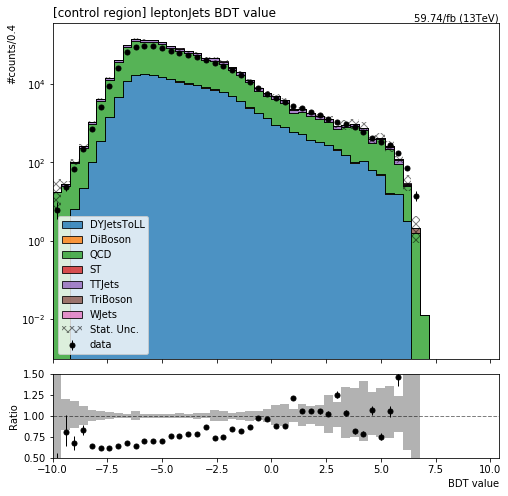

In [30]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['mva_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['mva_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['mva_cat']['data'].sum('cat'), output['mva_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets BDT value', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

#plt.savefig(join(FIG_DIR, "electronmodel_BDT.pdf"), bbox_inches='tight')
#plt.close()

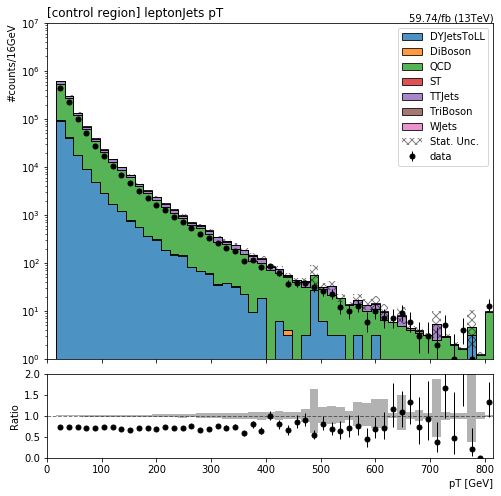

In [32]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['pt_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['pt_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['pt_cat']['data'].sum('cat'), output['pt_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets pT', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

#plt.savefig(join(FIG_DIR, "electronmodel_Pt.pdf"), bbox_inches='tight')
#plt.close()

## Muon Model, Data Background

In [33]:
class LeptonJetsMuProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        neufrac_axis      = hist.Bin("neufrac", "neutral energy fraction", 50, 0, 1.001)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lambda', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsilon', 'jet sub - epsilon', 50, 0, 0.25)
        ecf1_axis    = hist.Bin('ecf1', 'energy correlation function - e1', 50, 0, 200)
        ecf2_axis    = hist.Bin('ecf2', 'energy correlation function - e2', 50, 0, 500)
        ecf3_axis    = hist.Bin('ecf3', 'energy correlation function - e3', 50, 0, 300)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis),
            "neufrac": hist.Hist("#counts/0.02", dataset_axis, neufrac_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis),
            "lambda": hist.Hist("#counts/0.16", dataset_axis, lambda_axis),
            "epsilon": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis),
            "ecf1": hist.Hist("#counts/4", dataset_axis, ecf1_axis),
            "ecf2": hist.Hist("#counts/10", dataset_axis, ecf2_axis),
            "ecf3": hist.Hist("#counts/6", dataset_axis, ecf3_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        
        if len(dataset)!=1:
            #wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            #wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'],
                    py=df['gen_p4.fCoordinates.fY'],
                    pz=df['gen_p4.fCoordinates.fZ'],
                    energy=df['gen_p4.fCoordinates.fT'],
                    pid=df['gen_pid'],
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            #wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        absd0 = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0)
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'], **{
            "px": df['pfjet_p4.fCoordinates.fX'],
            "py": df['pfjet_p4.fCoordinates.fY'],
            "pz": df['pfjet_p4.fCoordinates.fZ'],
            "energy": df['pfjet_p4.fCoordinates.fT'],
            "neufrac": ((df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT']),
            "maxd0": absd0.max().content,
            "mind0": absd0.min().content,
            "tkiso": df['pfjet_tkIsolation05'],
            "pfiso": df['pfjet_pfIsolation05'],
            "spreadpt": df['pfjet_ptDistribution'],
            "spreaddr": df['pfjet_dRSpread'],
            "lambda": df['pfjet_subjet_lambda'],
            "epsilon": df['pfjet_subjet_epsilon'],
            "ecf1": df['pfjet_subjet_ecf1'],
            "ecf2": df['pfjet_subjet_ecf2'],
            "ecf3": df['pfjet_subjet_ecf3'],
            })
        
        vals={
            'target': leptonjets.pt.zeros_like().flatten(),
            'pt': leptonjets.pt.flatten(),
            'eta': leptonjets.eta.flatten(),
        }
        
        vals.update( {k: leptonjets[k].flatten() for k in output.keys() if (k not in vals and k != 'mva')} )
        
        dfleptonjets = pd.DataFrame(vals)
        
        dfleptonjets.fillna(0)
        
        feature_cols = [n for n in dfleptonjets.keys() if n != "target"]

        dfleptonjets2 = dfleptonjets[feature_cols]
        
        xglj = xgb.DMatrix(dfleptonjets2)
        
        predictions = xgbm_mu.predict(xglj)
        
        offsets = leptonjets.pt.offsets
        jaggedpredictions = JaggedArray.fromoffsets(offsets, predictions)
        leptonjets.add_attributes(mva=jaggedpredictions)
        
        mumask = leptonjets.neufrac <= 0.8
        leptonjets = leptonjets[mumask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
        leptonjets_ = dileptonjets[controlregion.flatten()]
        wgt = wgt[controlregion.flatten()]
        wgts= (leptonjets_.pt.ones_like()*wgt).flatten()

        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=wgts)
        output['eta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), weight=wgts)
        output['neufrac'].fill(dataset=dataset, neufrac=leptonjets_.neufrac.flatten(), weight=wgts)
        output['maxd0'].fill(dataset=dataset, maxd0=leptonjets_.maxd0.flatten(), weight=wgts)
        output['mind0'].fill(dataset=dataset, mind0=leptonjets_.mind0.flatten(), weight=wgts)
        output['tkiso'].fill(dataset=dataset, tkiso=leptonjets_.tkiso.flatten(), weight=wgts)
        output['pfiso'].fill(dataset=dataset, pfiso=leptonjets_.pfiso.flatten(), weight=wgts)
        output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets_.spreadpt.flatten(), weight=wgts)
        output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets_.spreaddr.flatten(), weight=wgts)
        output['lambda']  .fill(**{"dataset": dataset, "lambda": leptonjets_['lambda'].flatten(), 'weight': wgts})
        output['epsilon'].fill(dataset=dataset, epsilon=leptonjets_.epsilon.flatten(), weight=wgts)
        output['ecf1'].fill(dataset=dataset, ecf1=leptonjets_.ecf1.flatten(), weight=wgts)
        output['ecf2'].fill(dataset=dataset, ecf2=leptonjets_.ecf2.flatten(), weight=wgts)
        output['ecf3'].fill(dataset=dataset, ecf3=leptonjets_.ecf3.flatten(), weight=wgts)
        output['mva'].fill(dataset=dataset, mva=leptonjets_.mva.flatten(), weight=wgts)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        
        for k in origidentity:
            # scale
            accumulator[k].scale(bkgscales, axis='dataset')
            # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        
        return accumulator

In [34]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetsMuProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 6847/6847 [14:45<00:00,  7.73items/s]


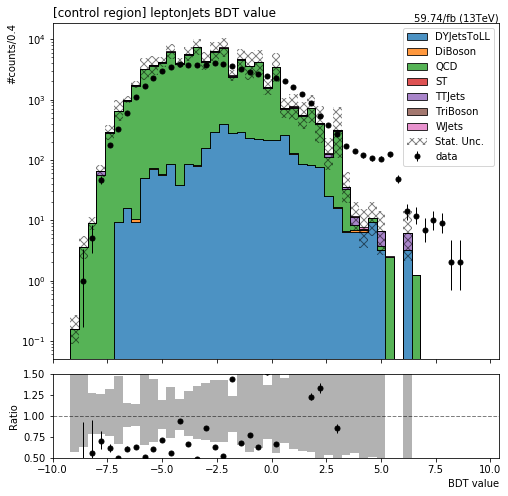

In [36]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['mva_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['mva_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['mva_cat']['data'].sum('cat'), output['mva_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets BDT value', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

#plt.savefig(join(FIG_DIR, "muonmodel_BDT.pdf"), bbox_inches='tight')
#plt.close()

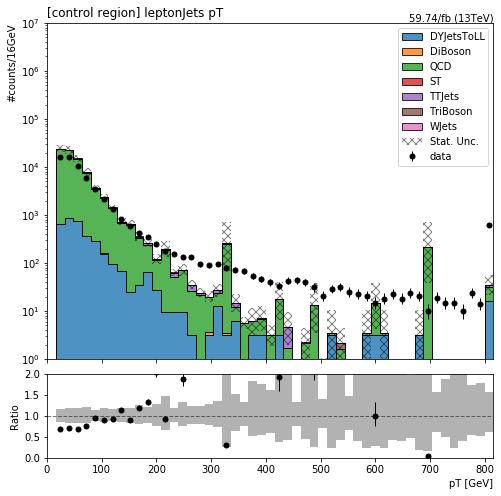

In [38]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['pt_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['pt_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['pt_cat']['data'].sum('cat'), output['pt_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets pT', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

#plt.savefig(join(FIG_DIR, "muonmodel_Pt.pdf"), bbox_inches='tight')
#plt.close()